In [2]:
from __future__ import annotations

import typing
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import torch

In [3]:
# Move to project root
from pathlib import Path
import os

if not Path("./src/kernels").is_dir():
    for parent_path in Path.cwd().parents:
        if (parent_path / "src/kernels").is_dir():
            os.chdir(parent_path)
            break
    else:
        raise FileNotFoundError("Can't find project root")

assert Path("./src/kernels").is_dir()

In [ ]:
from pytorch_semifield_conv import SelectSemifield, BroadcastSemifield

In [ ]:
plt.set_cmap("Spectral_r");

In [6]:
resolution = 1001
kernel_size = 1001

In [7]:
def plot_3d(
        data: torch.Tensor,
        batch: int = 0,
        channel: int = 0,
        ax=None,
        title: str = "",
        vmin=0,
        vmax=1,
        imshow: bool = False,
):
    assert len(data.shape) == 4
    data = data[batch, channel].numpy(force=True)
    xs, ys = np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[0]))
    if ax is None:
        _, ax = plt.subplots(layout="compressed", subplot_kw={"projection": "3d"})
    ax.plot_surface(xs, ys, data, vmin=vmin, vmax=vmax, cmap="Spectral_r")
    ax.set_zlim(vmin, vmax)
    ax.set_title(title)

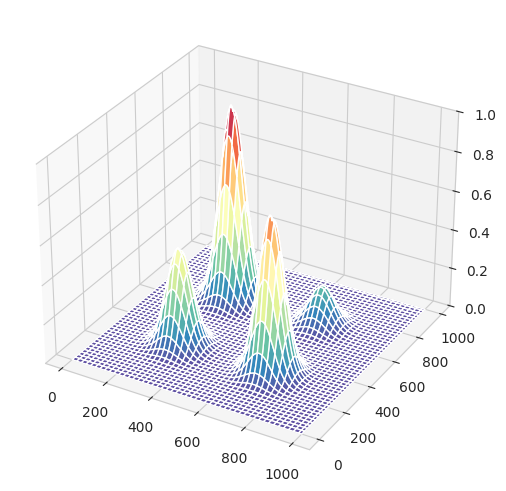

In [8]:
with torch.device("cuda"):
    space = torch.linspace(0, 1, steps=resolution)
    space_2d = torch.cartesian_prod(space, space)
    test_loc = torch.tensor(
        [[0.3, 0.3], [0.7, 0.3], [0.3, 0.7], [0.7, 0.7]], dtype=torch.float32
    ).unsqueeze(1)
    test_cov = 1e-2 * torch.eye(2).reshape(1, 2, 2).broadcast_to(len(test_loc), 2, 2)
    data_peaked = (
        torch.einsum(
            "cbx,cxX,cbX->cb",
            space_2d - test_loc,
            torch.inverse(test_cov),
            space_2d - test_loc,
        )
        .reshape(1, -1, resolution, resolution)
        .mul(-2)
        .exp()
        .mul(torch.tensor([0.5, 1, 0.8, 0.2], dtype=torch.float32).view(1, -1, 1, 1))
        .sum(1, keepdim=True)
    )
    # data_peaked += torch.randn_like(data_peaked) * 0.01
plot_3d(data_peaked)

In [9]:
def plot_2d(
        data: torch.Tensor,
        batch: int = 0,
        channel: int = 0,
        ax=None,
        title: str = "",
        vmin=0,
        vmax=1,
        imshow: bool = False,
):
    assert len(data.shape) == 4
    data = data[batch, channel].numpy(force=True)
    if ax is None:
        _, ax = plt.subplots(layout="compressed")
    if imshow:
        ax.imshow(data, vmin=vmin, vmax=vmax)
        ax.axis("off")
    else:
        ax.matshow(data, vmin=vmin, vmax=vmax)
    ax.set_title(title)

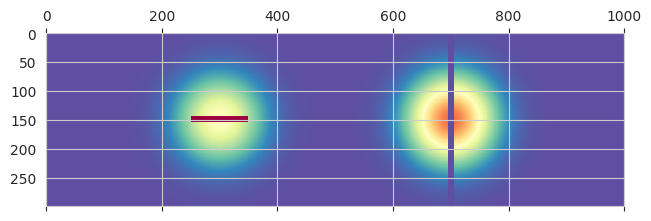

In [36]:
data_slashed = data_peaked[:, :, 150:450].clone()
data_slashed[0, 0, 145:155, 250:350] = 1
data_slashed[0, 0, :, 695:705] = 0
# data_slashed[0, 0, 300:315, 500:900] = 0
# data_slashed[0, 0, 300:315, 200:400] = 1
# data_slashed[0, 0, 500:650, 295:305] = 0
plot_2d(data_slashed)

In [11]:
class Adjunction(typing.NamedTuple):
    dilation: Callable
    erosion: Callable
    name: str

In [12]:
def plot_kernels(kernel: torch.Tensor, vmin=-1, vmax=0):
    assert len(kernel.shape) == 4
    kernel = kernel.numpy(force=True)[:, 0]
    _, axs = plt.subplots(ncols=len(kernel), layout="compressed", figsize=(10, 10))
    for k, ax in zip(kernel, axs):
        ax.matshow(k, vmin=vmin, vmax=vmax)

torch.Size([6, 1, 1001, 1001])


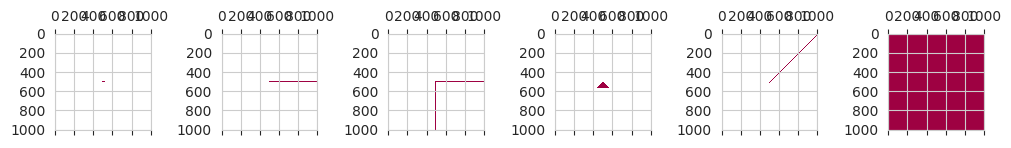

In [13]:
INF = float("inf")
flat_kernels = torch.full((6, 1, kernel_size, kernel_size), -INF, device="cuda")
width = 5
klow = kernel_size // 2 - width
khi = kernel_size // 2 + width
flat_kernels[0, :, klow:khi, klow: khi + width * 3] = 0
flat_kernels[[1, 2], :, klow:khi, klow:] = 0
flat_kernels[2, :, klow:, klow:khi] = 0

tri_size = kernel_size // 15
for size in range(tri_size, 0, -1):
    tri_idx = torch.tril_indices(size, size)
    flat_kernels[3, :, tri_idx[0] + kernel_size // 2, kernel_size // 2 + tri_idx[1]] = (
        0  # -size / tri_size
    )
    flat_kernels[3, :, tri_idx[0] + kernel_size // 2, kernel_size // 2 - tri_idx[1]] = (
        0  # -size / tri_size
    )

for size in range(width):
    flat_kernels[4, 0] = torch.diagonal_scatter(
        flat_kernels[4, 0], torch.zeros((kernel_size - size,)), offset=size
    )

flat_kernels[4, 0, :klow, :klow] = -INF
flat_kernels[4, 0] = flat_kernels[4, 0].flip(0).clone()
flat_kernels[5] = 0
print(flat_kernels.shape)
plot_kernels(flat_kernels)

In [14]:
test_img = torch.zeros((1, 6, 1000, 1000), device="cuda")
test_img[..., 500, 500] = 1
test_img_neg = 1 - test_img
_, test_op = SelectSemifield.tropical_max().compile(
    test_img, flat_kernels, groups=6, padding=kernel_size // 2
)
_, test_opn = SelectSemifield.tropical_min()._compile(
    test_img, flat_kernels, groups=6, padding=kernel_size // 2
)
test_res, _ = test_op(test_img, flat_kernels)
test_res_neg, _ = test_opn(test_img_neg, flat_kernels)
test_res_closed, _ = test_opn(test_res, flat_kernels)
test_res.shape

torch.Size([1, 6, 1000, 1000])

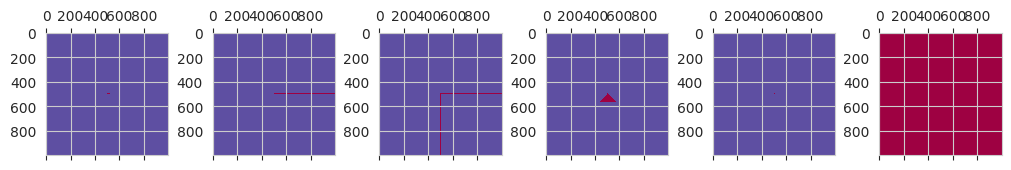

In [15]:
plot_kernels(test_res.movedim(0, 1), vmin=0, vmax=1)

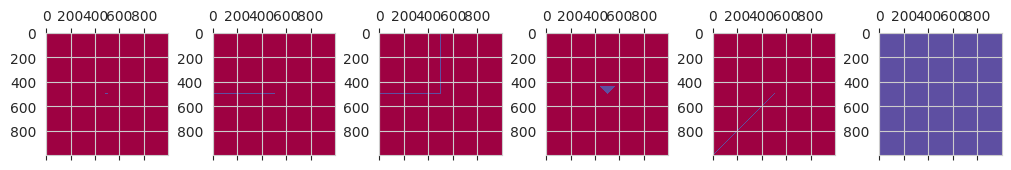

In [16]:
plot_kernels(test_res_neg.movedim(0, 1), vmin=0, vmax=1)

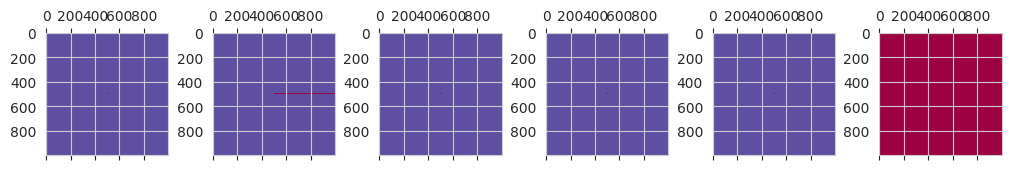

In [17]:
plot_kernels(test_res_closed.movedim(0, 1), vmin=0, vmax=1)

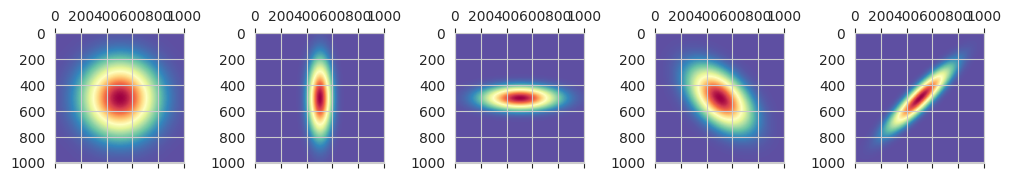

In [18]:
with torch.device("cuda"):
    assert kernel_size % 2
    space = torch.linspace(0, 1, steps=kernel_size)
    space_2d = torch.cartesian_prod(space, space)
    space_2d -= space_2d[kernel_size * kernel_size // 2].clone()
    test_cov = 0.4 * torch.tensor(
        [
            [[0.3, 0], [0, 0.3]],
            [[0.3, 0], [0, 0.03]],
            [[0.03, 0], [0, 0.3]],
            [[0.2, 0.1], [0.1, 0.2]],
            [[0.2, -0.18], [-0.18, 0.2]],
            # [[0.5, 0], [0, 0.05]],
        ],
        dtype=torch.float32,
    )
    rounded_kernels = (
        torch.einsum(
            "bx,cxX,bX->cb",
            space_2d,
            torch.inverse(test_cov),
            space_2d,
        )
        .reshape(-1, 1, kernel_size, kernel_size)
        .mul(-2)
        .exp()
    )

    rounded_kernels -= (
        rounded_kernels.view(-1, kernel_size * kernel_size)
        .max(1)
        .values.view(-1, 1, 1, 1)
    )
    # rounded_kernels[rounded_kernels <= -0.97] = -1
    # rounded_kernels[rounded_kernels > -0.05] = 0

plot_kernels(rounded_kernels)

In [ ]:
ss_adj = Adjunction(
    SelectSemifield.tropical_max().dynamic(20),
    SelectSemifield.tropical_min().dynamic(20),
    "Select",
)
un_adj = Adjunction(
    BroadcastSemifield.tropical_max().dynamic(),
    BroadcastSemifield.tropical_min().dynamic(),
    "Unfold",
)

In [ ]:
def plot_adjunction(
        data: torch.Tensor,
        adj: Adjunction,
        kernel: torch.Tensor,
        suptitle: str = "",
        surface: bool = True,
        permissible_error: float = 0.00005,
        **conv_kwargs,
):
    if surface:
        plot_fn = plot_3d
    else:
        plot_fn = plot_2d
    fig, axss = plt.subplots(
        nrows=2,
        ncols=3,
        subplot_kw={"projection": "3d"} if surface else {},
        layout="compressed",
        figsize=(10, 10),
    )
    plot_fn(data, ax=axss[0, 0], title="Original: $F$", imshow=True)
    plot_fn(
        kernel.movedim(0, 1),
        ax=axss[1, 0],
        title="Kernel: $G$",
        vmin=-1,
        vmax=0,
        imshow=True,
    )

    eroded = adj.erosion(data, kernel, **conv_kwargs)
    opened = adj.dilation(eroded, kernel, **conv_kwargs)

    dilated = adj.dilation(data, kernel, **conv_kwargs)
    closed = adj.erosion(dilated, kernel, **conv_kwargs)

    plot_fn(eroded, ax=axss[0, 1], title=r"Eroded: $F \boxminus G$", imshow=True)
    plot_fn(
        opened,
        ax=axss[0, 2],
        title=r"Opened: $(F \boxminus G) \boxplus G$",
        imshow=True,
    )

    plot_fn(dilated, ax=axss[1, 1], title=r"Dilated: $F \boxplus G$", imshow=True)
    plot_fn(
        closed,
        ax=axss[1, 2],
        title=r"Closed: $(F \boxplus G) \boxminus G$",
        imshow=True,
    )

    dilation_err = data - dilated
    erosion_err = eroded - data
    opened_err = opened - data
    closed_err = data - closed

    for errs, name in zip(
            (dilation_err, erosion_err, opened_err, closed_err),
            ("Dilation", "Erosion", "Opening", "Closing"),
    ):
        if (errs > permissible_error).any():
            plot_fn(
                errs, title=f"{suptitle + ': ' if suptitle else ''}errors in {name}"
            )

    fig.suptitle(suptitle)
    fig.show()

    assert (dilation_err < permissible_error).all(), (
        f"{suptitle}: Dilation should always be >="
    )
    assert (erosion_err < permissible_error).all(), (
        f"{suptitle}: Erosion should always be <="
    )
    assert (closed_err < permissible_error).all(), (
        f"{suptitle}: Closing should always be >=, {closed_err.max()=} {closed_err.argmax()=}"
    )
    assert (opened_err < permissible_error).all(), (
        f"{suptitle}: Opening should always be <=, {opened_err.max()=}"
    )

In [21]:
# img (500x500) (+) kernel (501x501) ~ 110ms, 7000 loops
# %timeit ss_adj.erosion(data_peaked, rounded_kernels[3:4], padding=kernel_size // 2)

In [22]:
run_timings = False
if run_timings:
    %timeit ss_adj.erosion(data_peaked, rounded_kernels[3:4], padding=kernel_size // 2)
    %timeit un_adj.erosion(data_peaked, rounded_kernels[3:4], padding=kernel_size // 2)
    %timeit tr_adj.erosion(data_peaked, rounded_kernels[3:4], padding=kernel_size // 2)

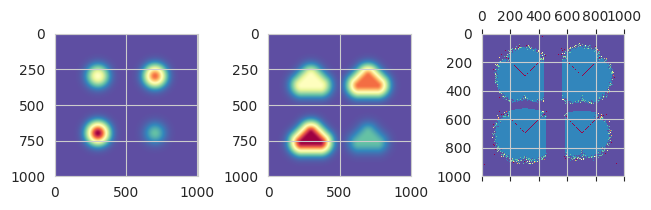

In [23]:
dg = (data_peaked + torch.randn_like(data_peaked) * 1e-5).clone().requires_grad_(True)
test_res = ss_adj.dilation(dg, flat_kernels[3:4], padding=kernel_size // 2)
test_res.sum().backward()
torch.cuda.synchronize()
_, test_axs = plt.subplots(ncols=3, layout="compressed")
test_axs[0].imshow(dg.numpy(force=True)[0, 0], vmin=0, vmax=1)
test_axs[1].imshow(test_res.numpy(force=True)[0, 0], vmin=0, vmax=1)
test_axs[2].matshow(dg.grad.numpy(force=True)[0, 0], vmin=0, vmax=10)
plt.show()

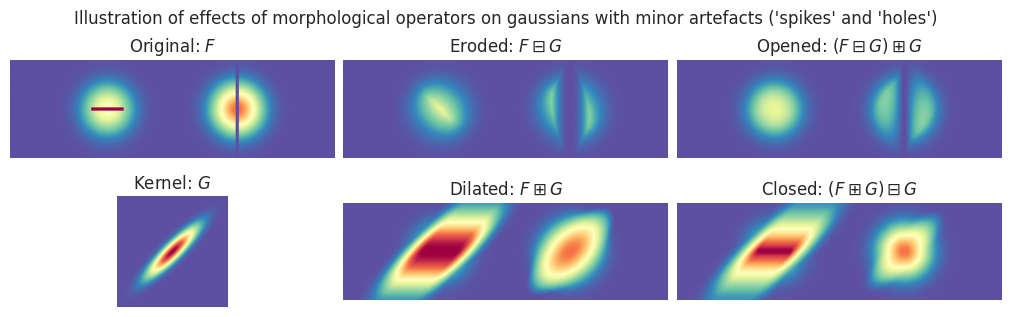

In [40]:
plot_adjunction(
    data_slashed,
    ss_adj,
    rounded_kernels[4:5, :, ::2, ::2],
    padding=kernel_size // 4,
    surface=False,
    permissible_error=0.0005,
    suptitle="Illustration of effects of morphological operators on gaussians with minor artefacts ('spikes' and 'holes')",
)

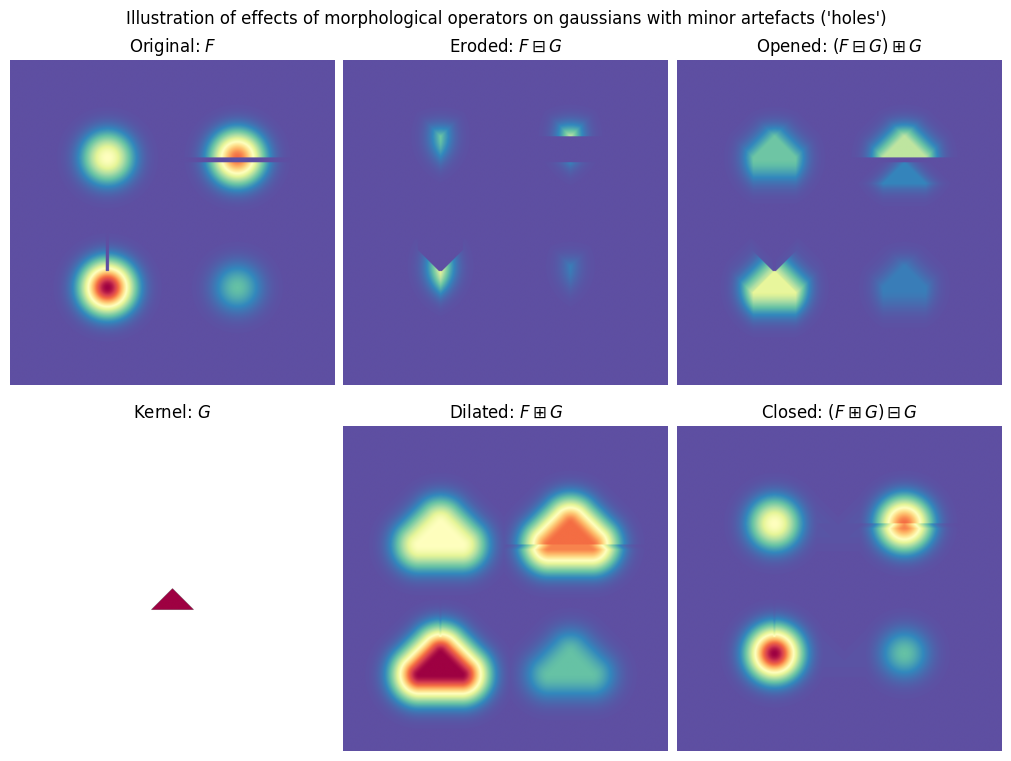

In [58]:
plot_adjunction(
    data_slashed,
    ss_adj,
    flat_kernels[3:4],
    padding=kernel_size // 2,
    surface=False,
    permissible_error=0.0005,
)

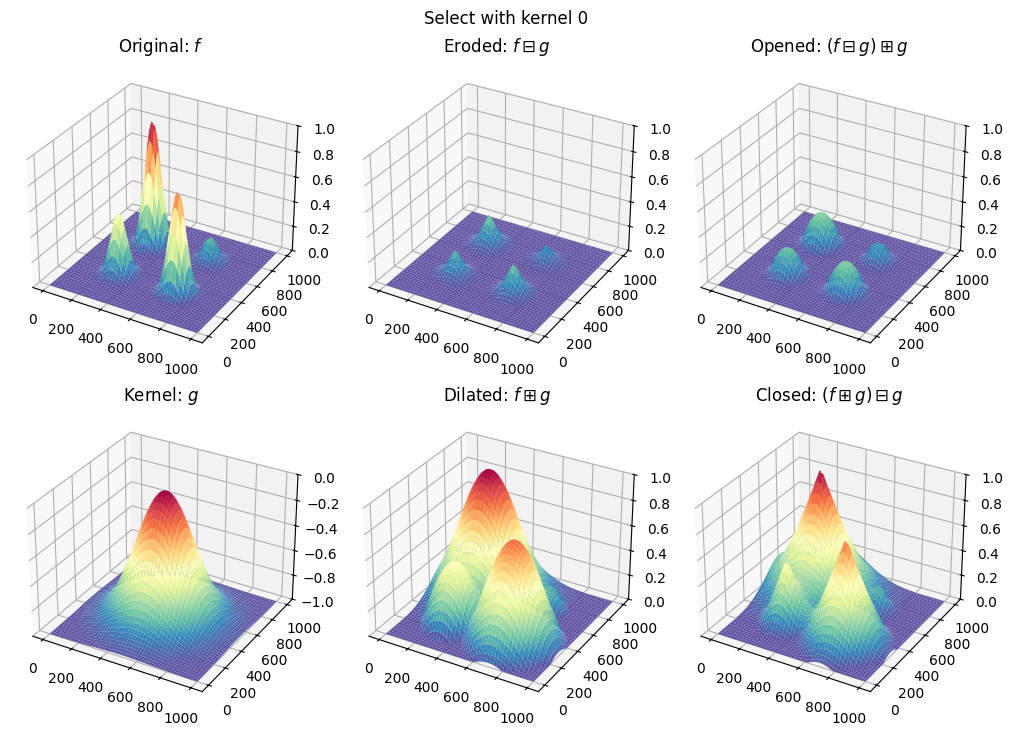

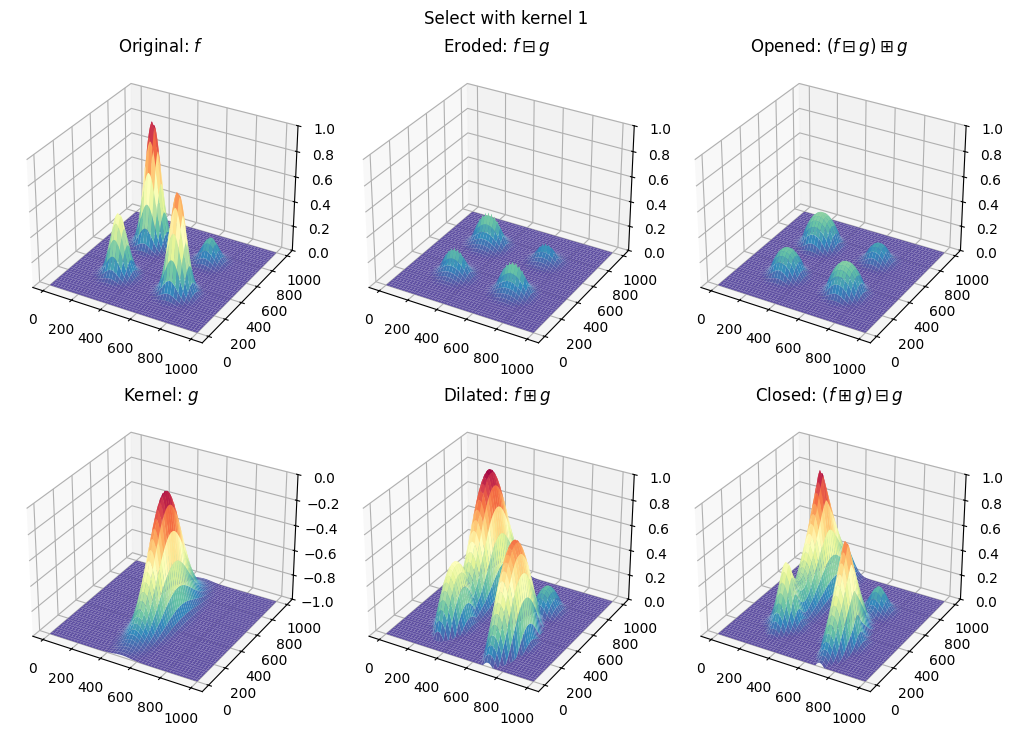

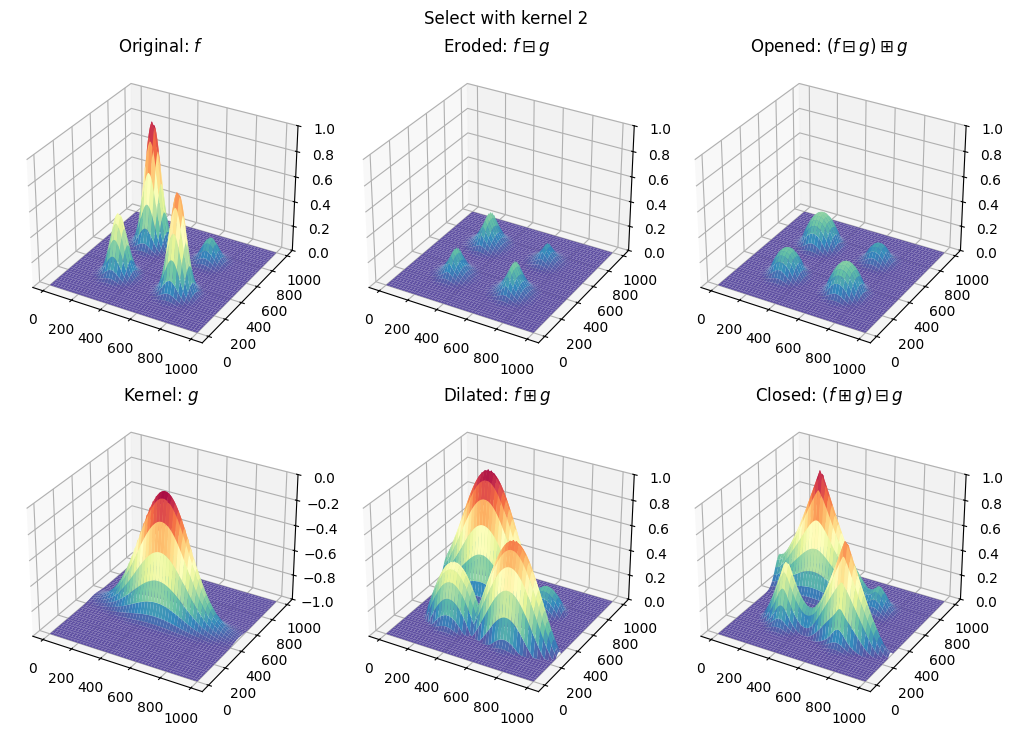

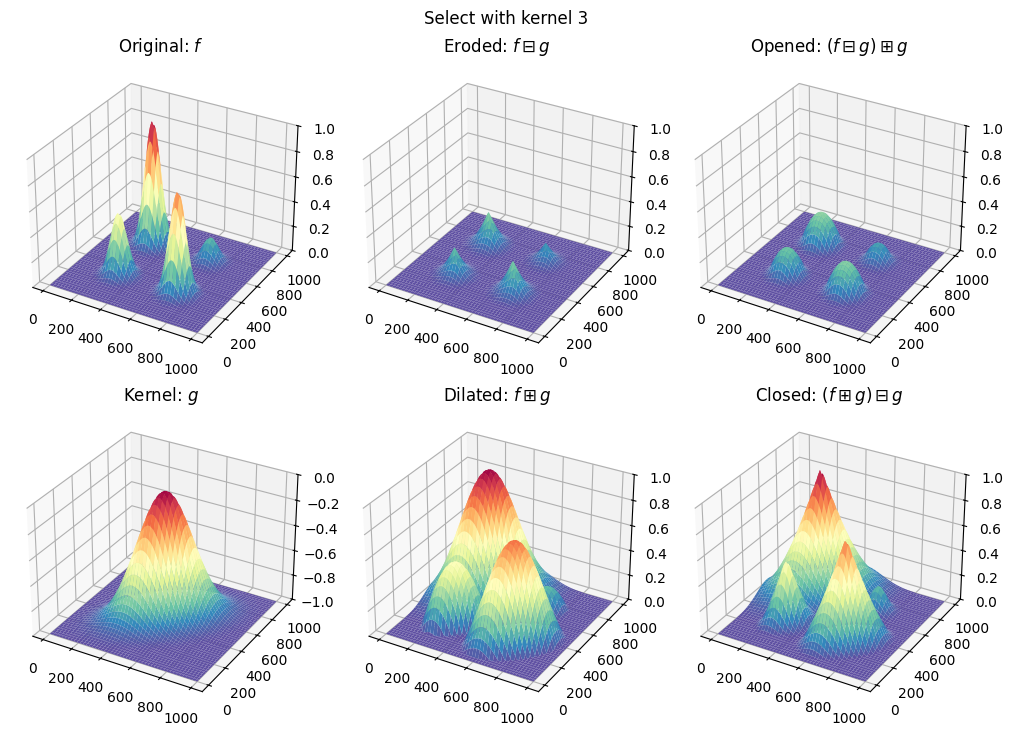

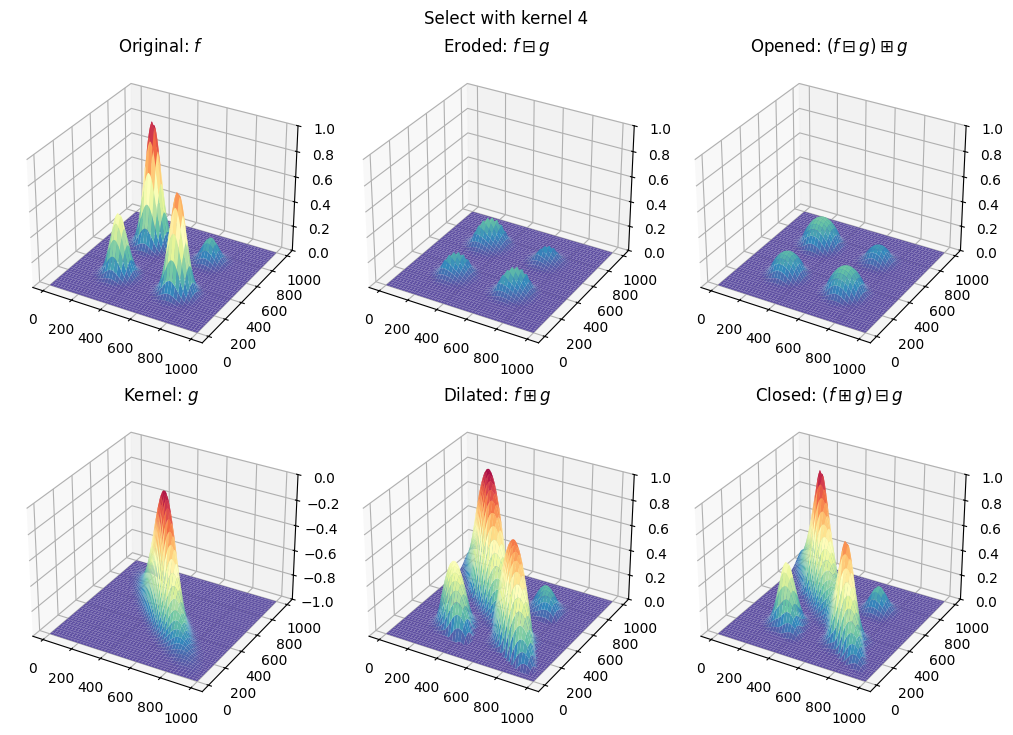

In [52]:
from itertools import product


def check_all(data, kernel, run_all: bool = False):
    adjs = (ss_adj, tr_adj, un_adj) if run_all else (ss_adj,)
    for adj, (k_nr, kernel) in product(adjs, enumerate(kernel)):
        plot_adjunction(
            data,
            adj,
            kernel.unsqueeze(0),
            suptitle=f"{adj.name} with kernel {k_nr}",
            padding=kernel_size // 2,
            surface=True,
        )


check_all(data_peaked, rounded_kernels)

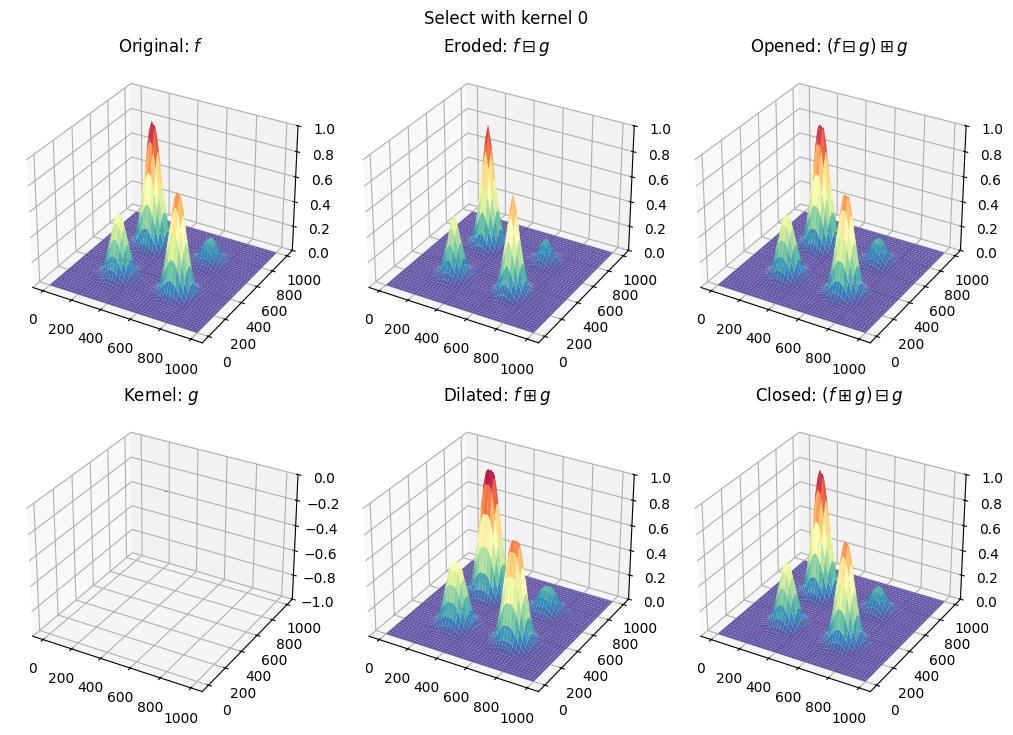

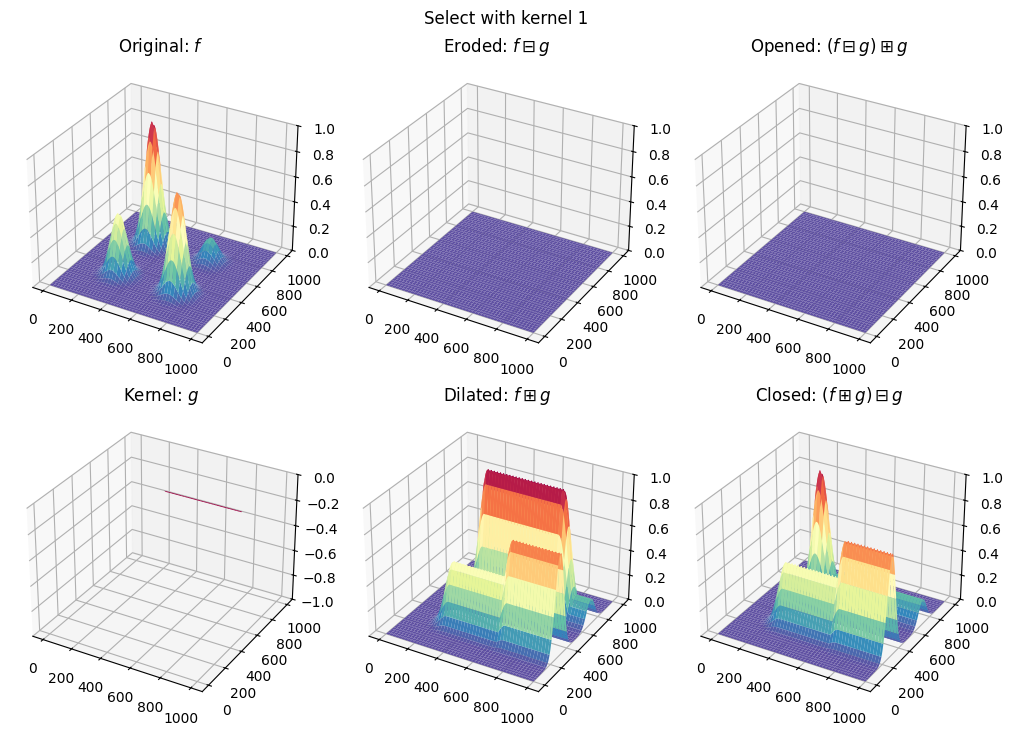

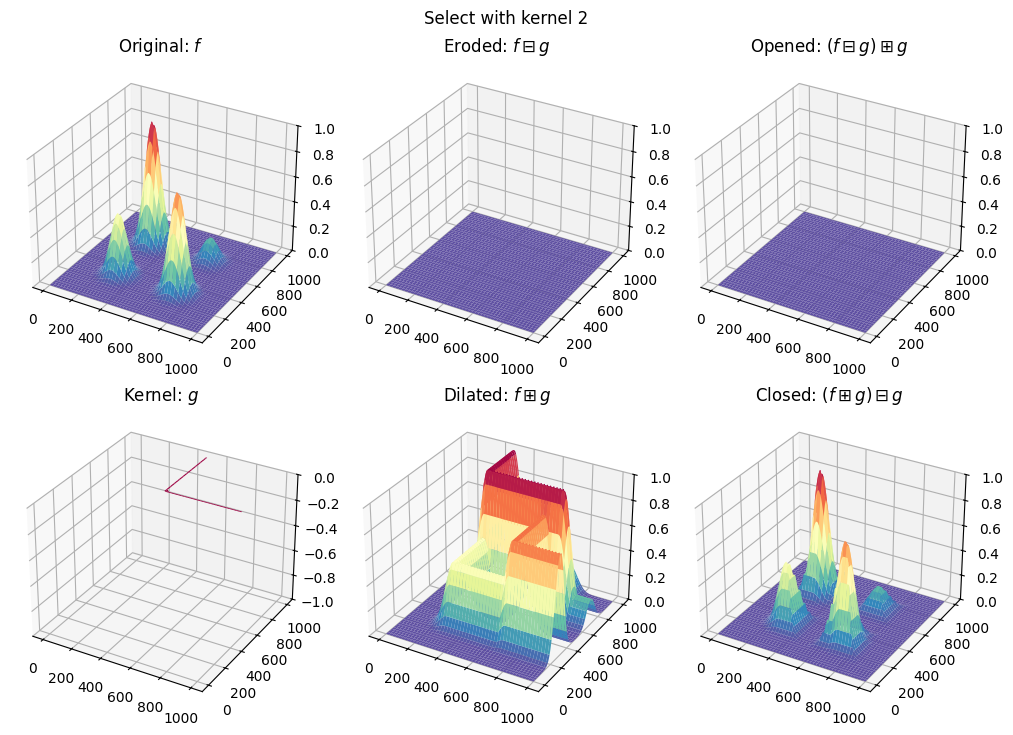

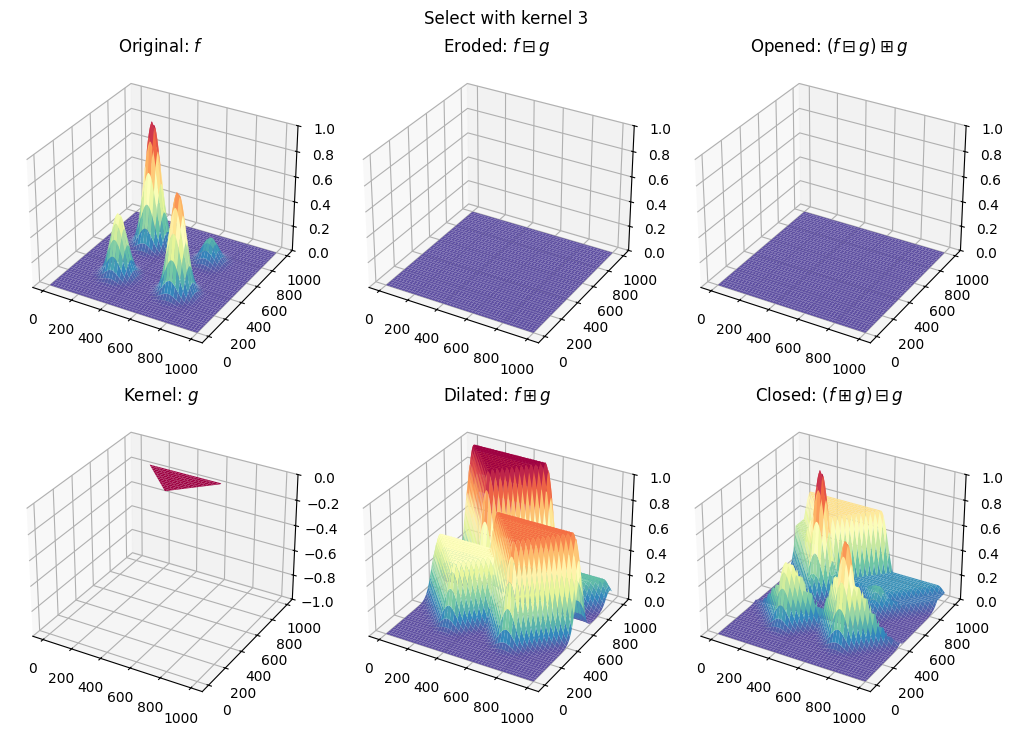

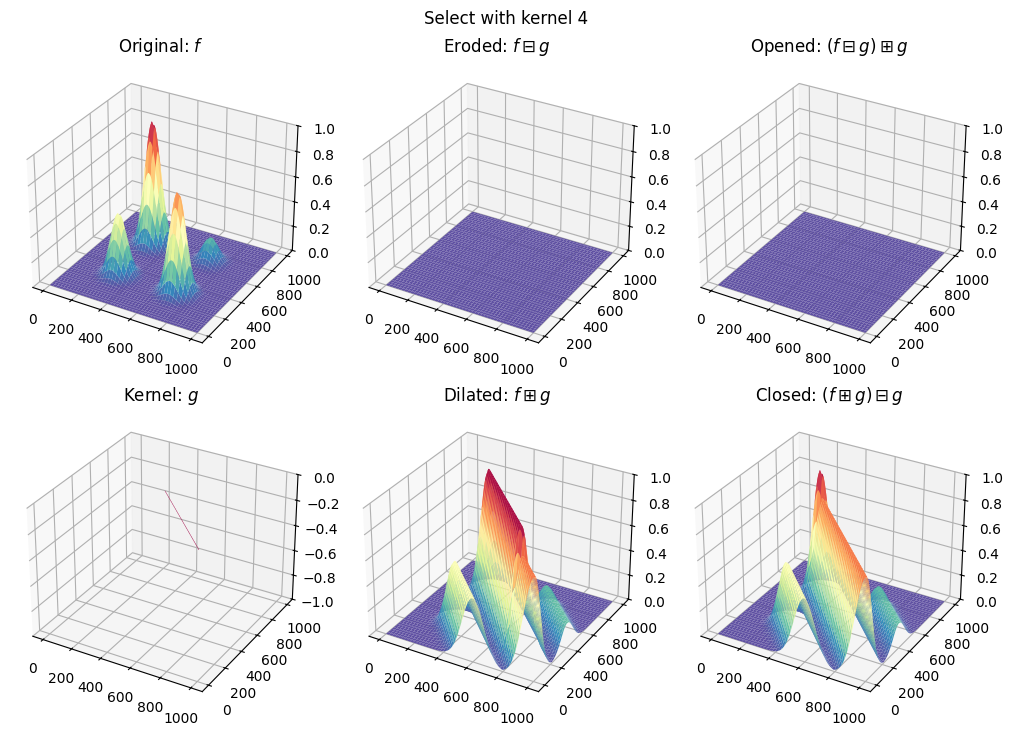

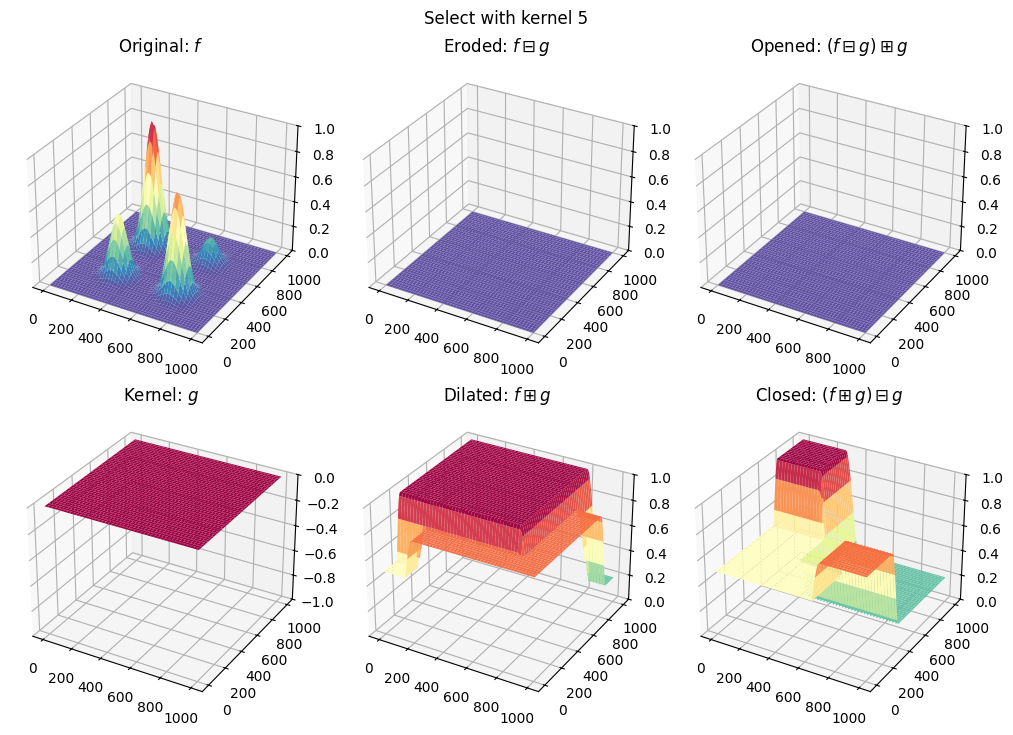

In [53]:
check_all(data_peaked, flat_kernels)